In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import pandas as pd
from pylab import *
import scipy
import sklearn
from sklearn.metrics.pairwise import euclidean_distances
import itertools

dataset=pd.read_csv('train.csv', sep=',',header=0)
label=list(dataset.label)
data=np.array(dataset.iloc[:,1:])

Label: 4


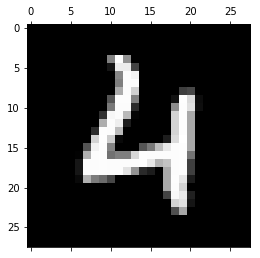

<function __main__.show_image>

In [2]:
def show_image(n):
    print("Label:",label[n])
    t= data[n].reshape(28,28)
    plt.matshow(t, cmap='gray')
    plt.show()
interact(show_image,n=(0,41999))

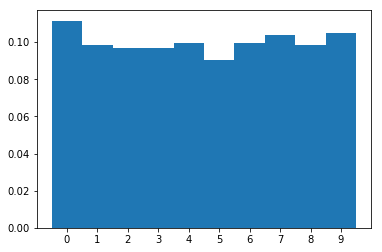

In [3]:
from collections import Counter
def show_prior_prob():
    labels, counts = zip(*Counter(label).items())
    total = sum(counts)
    pp = list(map(lambda x: x/float(total), counts))
    sorted_pp = [pp for _,pp in sorted(zip(labels,pp))]
    plt.bar(labels,sorted_pp,1)
    plt.xticks(arange(10),arange(10))
    plt.show()
show_prior_prob()


In [11]:
def mostNearestNeighbor(inX, dataMat):
    dataSetSize = dataMat.shape[0]
    diffMat = tile(inX,(dataSetSize,1)) - dataMat
    sqDiffMat = diffMat**2
    sqDistances = sqDiffMat.sum(axis=1)
    distances = list(sqDistances**0.5)
    targetIndex = distances.index(min(distances))
    return targetIndex

def findUniqDigitsIndex():
    res = []
    for i in range(10):
        res.append(label.index(i))
    return res

def findNearestNeighborQuestion():
    for i in findUniqDigitsIndex():
        dataRemain = np.delete(array(data),(i), axis=0)
        labelRemain = np.delete(array(label),(i), axis=0)
        predictedIndex = mostNearestNeighbor(data[i],dataRemain)
        predictedValue = labelRemain[predictedIndex]
        print("Predicted Value :" + str(predictedValue) + " Actual value :" + str(label[i]))
        if str(predictedValue)!=str(label[i]):
            print("*")
findNearestNeighborQuestion()

Predicted Value :0 Actual value :0
Predicted Value :1 Actual value :1
Predicted Value :2 Actual value :2
Predicted Value :5 Actual value :3
*
Predicted Value :4 Actual value :4
Predicted Value :5 Actual value :5
Predicted Value :6 Actual value :6
Predicted Value :7 Actual value :7
Predicted Value :8 Actual value :8
Predicted Value :9 Actual value :9


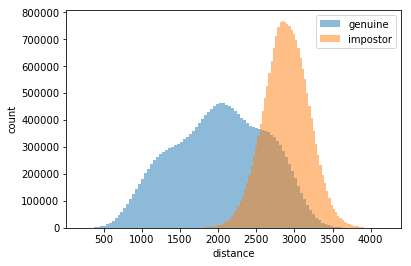

In [16]:
genuine,impostor =[],[]
def plotHistogram():
    dataMatBinary,labelMatBinary = [],[]
    for i in range(len(label)):
        if label[i]==0 or label[i]==1:
            dataMatBinary.append(data[i])
            labelMatBinary.append(label[i])
    dists = sklearn.metrics.pairwise.euclidean_distances(dataMatBinary)
    for (i_index,i),(j_index,j) in itertools.combinations(enumerate(labelMatBinary), 2):
        genuine.append(dists[i_index][j_index]) if i==j else impostor.append(dists[i_index][j_index])
    bins = 100
    labels = plt.subplot()
    labels.set_xlabel("distance")
    labels.set_ylabel("count")
    plt.hist(genuine, bins, alpha=0.5, label='genuine')
    plt.hist(impostor, bins, alpha=0.5, label='impostor')
    plt.legend(loc='upper right')
    plt.show()
    return dists
    
dists = plotHistogram()

NameError: name 'genuine' is not defined

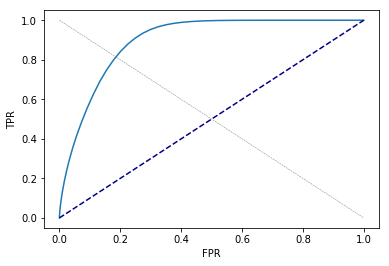

In [17]:
def plotROC(genuine,impostor):
    tprarray,fprarray = [],[]
    genuine = np.array(genuine)
    impostor = np.array(impostor)
    for distance in range(int(amin(dists)),int(amax(dists)),50):
        tp = len(impostor[impostor>= distance])
        fp = len(genuine[genuine>= distance])
        fn = len(impostor) - tp
        tn = len(genuine) - fp
        tpr = tp / len(impostor)
        fpr = fp / len(genuine)
        tprarray.append( tpr )
        fprarray.append( fpr )
        if abs(fpr-1+tpr) < 0.03:
            eer = (fp+fn)/(tp+tn+fn+fp)
            print("equal error rate: ",eer)
    print("guess rate: ",len(impostor)/(len(impostor)+len(genuine)))
    
    plt.plot(fprarray,tprarray)
    plt.plot([0,1],[0,1],color='navy',linestyle='--')#roc when choose randomly
    plt.plot([0,1],[1,0],color='gray',linestyle='--',linewidth=0.5)#to get equal error rate
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
    
plotROC(genuine,impostor)

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
from scipy.spatial.distance import cdist
from multiprocessing import Pool

# def nearestNeighborK(inX, dataMat, labelMat, k):
#     dataSetSize = dataMat.shape[0]
#     diffMat = tile(inX,(dataSetSize,1)) - dataMat
#     sqDiffMat = diffMat**2
#     sqDistances = sqDiffMat.sum(axis=1)
#     distances = sqDistances**0.5
#     sortedDistIndicies = distances.argsort()
#     classCount={}
#     for i in range(1,k+1):
#         voteIlabel = labelMat[sortedDistIndicies[i]]
#         classCount[voteIlabel] = classCount.get(voteIlabel,0) + 1
#     return max(classCount, key=classCount.get)

# def nearestNeighborKPairwise(inX, dataMat, labelMat, k):    
#     dists = sklearn.metrics.pairwise.euclidean_distances(inX,dataMat)
#     smallestKIndicies = np.argpartition(dists,k)[0][:k]
#     classCount={}
#     for i in range(0,k):
#         voteIlabel = labelMat[smallestKIndicies[i]]
#         classCount[voteIlabel] = classCount.get(voteIlabel,0) + 1
#     return max(classCount, key=classCount.get)

def reducedIndicies(testData, trainData, k, offset=0):
    dists = scipy.spatial.distance.cdist(testData,trainData, 'euclidean')
    sortedIndicies = np.argpartition(dists,k)
    result=[]
    for i, row in enumerate(sortedIndicies):
        r=[]
        for x in row[:k]:
            r.append((dists[i][x], x+offset))
        result.append(r)
    return result

## if testLabel given, it's a cross validation
def nearestNeighborKCdist(testData, trainData, trainLabel, k, testLabel=None):
    p = Pool(4)
    testOffset = len(testData)//2
    trainOffset = len(trainData)//2
    temp = p.starmap(reducedIndicies, [(testData[:testOffset], trainData[:trainOffset], k),
                            (testData[:testOffset], trainData[trainOffset:], k, trainOffset),
                            (testData[testOffset:], trainData[:trainOffset], k),
                            (testData[testOffset:], trainData[trainOffset:], k, trainOffset)])
    indicies = list(map(lambda x: x[0]+x[1],zip(temp[0], temp[1])))+list(map(lambda x: x[0]+x[1],zip(temp[2], temp[3])))                                                   
    sortedIndicies = [sorted(row) for row in indicies]
                                                            
    pred = []
    success = 0
    for ind, x in enumerate(sortedIndicies):
        classCount={}
        for i in range(0,k):
            voteIlabel = trainLabel[x[i][1]]
            classCount[voteIlabel] = classCount.get(voteIlabel,0) + 1
        if testLabel is not None: success += (max(classCount, key=classCount.get)==testLabel[ind])
        pred.append(max(classCount, key=classCount.get))
    successRate = success/len(testData)
    return successRate, pred

def generateConfusionMatrix(*fold):
    train_indices, test_indices, k = fold
    X_train = data[train_indices]
    Y_train = np.array(label)[train_indices]
    X_test = data[test_indices]
    Y_test = np.array(label)[test_indices]

    successRate, pred = nearestNeighborKCdist(X_test, X_train, Y_train, k, Y_test)
    print(confusion_matrix(array(pred), Y_test))
    return successRate

def performCrossValidation(sampleSize=None, k=3):
    if sampleSize is None: sampleSize = len(data)
    successRate = 0
    print("K is :", k)
    for train, test in (cross_validation.KFold(sampleSize, n_folds=3)):
        success = generateConfusionMatrix(train,test,k)
        successRate+=success
        print('success rate: ', success,'\n')
    print('\naverage success rate: ', successRate/3)

performCrossValidation()

K is : 3


/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[[1358    0    7    0    0    3    6    0    5    2]
 [   0 1561   17    2   16    0    1   22   11    3]
 [   2    1 1364    6    0    1    0    2    5    0]
 [   0    2    6 1369    0   20    0    0   20    7]
 [   0    2    2    0 1308    0    3    7    1   13]
 [   2    1    1   12    0 1227    8    0   30    4]
 [   7    4    1    1    5   11 1381    0    8    2]
 [   0    1   22    7    3    2    0 1414    4   23]
 [   1    1    4    9    0    3    0    0 1240    4]
 [   1    2    3    4   36    9    0   19   19 1309]]
success rate:  0.9665 

[[1339    0    8    1    2    3    8    0    2    4]
 [   0 1517   18    1   14    0    2   19   10    3]
 [   2    5 1329    9    0    0    0    3    5    1]
 [   0    0    5 1438    0   22    0    2   21   12]
 [   0    1    1    0 1325    1    1    1    8   16]
 [   3    1    0   18    0 1189    9    0   26    3]
 [   4    1    3    1    4   16 1358    0    6    0]
 [   0    6   29   11    3    1    0 1417    2   12]
 [   1    1    4   10

BlockingIOError: [Errno 35] Resource temporarily unavailable

1 and 9 areparticularly tricky to classify

In [7]:
testSet=pd.read_csv('test.csv', sep=',',header=0)
_, pred = nearestNeighborKCdist(testSet, data,label,3)
with open('submission.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    spamwriter.writerow(['ImageId','Label'])
    for i,r in enumerate(pred):
        spamwriter.writerow([i+1,r])